# 이변량 분석

---

# 0. 라이브러리

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rc('font', family='Malgun Gothic') # 한글 폰트 적용
mpl.rcParams["axes.unicode_minus"] = False # 마이너스 기호 깨짐 방지
plt.rcParams["figure.figsize"] = (20, 10) # 차트 사이즈 설정

---

# 1. 데이터 불러오기

## 1) emd-geo-master

In [2]:
emd_geo_master = gpd.read_file('../../data/서울생활이동/gis-master/move-emd-geo-master.shp')
emd_geo_master['emd_cd'] = emd_geo_master['emd_cd'].astype('int64')
display(emd_geo_master.head())
display(emd_geo_master.shape)

,sig_cd,sig_nm,emd_cd,emd_nm,geometry
0,11010,종로구,1101053,사직동,"POLYGON ((953808.688 1953047.862, 953817.563 1..."
1,11010,종로구,1101054,삼청동,"POLYGON ((954332.749 1955199.002, 954392.625 1..."
2,11010,종로구,1101055,부암동,"POLYGON ((953730.004 1955368.624, 953528.119 1..."
3,11010,종로구,1101056,평창동,"POLYGON ((953683.063 1959232.375, 953806.750 1..."
4,11010,종로구,1101057,무악동,"POLYGON ((952380.125 1953627.000, 952567.946 1..."


(425, 5)

## 2) 유동인구

- 평일
- 퇴근시간대(18-22시)
- 서울내 이동

In [11]:
move = pd.read_csv('../../data/서울생활이동/preprocessing/생활이동_행정동_202201_18-22시.csv')
display(move.head())
display(move.shape)

,대상연월,요일,도착시간,출발 행정동 코드,도착 행정동 코드,성별,나이,이동유형,평균 이동 시간(분),이동인구(합),출발시간
0,202201,월,18,1101053,1101053,F,0,EH,10,27.77,18
1,202201,월,18,1101053,1101053,F,15,EH,10,4.04,18
2,202201,월,18,1101053,1101053,F,15,EE,10,16.32,18
3,202201,월,18,1101053,1101053,F,15,HE,20,16.16,18
4,202201,월,18,1101053,1101053,F,15,WH,10,4.04,18


(14007446, 11)

# 2. 시각화

In [4]:
def show_geo(gdf, column):
    gdf.plot(column=column,
             legend=True,
             cmap='Blues',
             edgecolor='k',
             legend_kwds={'label': '명'})
    plt.axis('off')
    plt.tight_layout()
    # plt.savefig('예제1.png')
    plt.show()

- 퇴근시간 맞춤버스(or 순환버스)의 목적을 고려하여 **집으로 향하는 이동인구**만 추출
- WH(회사/학교->집), EH(기타->집), HH(집->집)

In [16]:
# 집으로 향하는 유동인구 유형만('WH', 'EH', 'HH')
move_home = move.loc[move['이동유형'].isin(['WH', 'EH', 'HH'])]
move_home.shape

(8453943, 11)

## 1) 행정동별 1~3km 이내 이동인구(합)

In [17]:
move_sum = move_home.groupby(by=['출발 행정동 코드', '도착 행정동 코드'], as_index=False)['이동인구(합)'].sum()
move_sum.head()

,출발 행정동 코드,도착 행정동 코드,이동인구(합)
0,1101053,1101053,10819.63
1,1101053,1101054,643.33
2,1101053,1101055,6083.85
3,1101053,1101056,3378.94
4,1101053,1101057,2024.91


In [19]:
move_sum.columns = ['emd_cd1', 'emd_cd2', '이동인구(합)']

merged = move_sum
merged = pd.merge(merged, emd_geo_master, left_on='emd_cd1', right_on='emd_cd')
merged = pd.merge(merged, emd_geo_master, left_on='emd_cd2', right_on='emd_cd')
merged = merged.loc[:, ['sig_nm_x', 'emd_cd1', 'emd_nm_x', 'sig_nm_y', 'emd_cd2', 'emd_nm_y', '이동인구(합)', 'geometry_x', 'geometry_y']]
merged.columns = ['sig_nm1', 'emd_cd1', 'emd_nm1', 'sig_nm2', 'emd_cd2', 'emd_nm2', '이동인구(합)', 'geo1', 'geo2']

display(merged.head())
display(merged.shape)

,sig_nm1,emd_cd1,emd_nm1,sig_nm2,emd_cd2,emd_nm2,이동인구(합),geo1,geo2
0,종로구,1101053,사직동,종로구,1101053,사직동,10819.63,"POLYGON ((953808.688 1953047.862, 953817.563 1...","POLYGON ((953808.688 1953047.862, 953817.563 1..."
1,종로구,1101054,삼청동,종로구,1101053,사직동,338.46,"POLYGON ((954332.749 1955199.002, 954392.625 1...","POLYGON ((953808.688 1953047.862, 953817.563 1..."
2,종로구,1101055,부암동,종로구,1101053,사직동,241.74,"POLYGON ((953730.004 1955368.624, 953528.119 1...","POLYGON ((953808.688 1953047.862, 953817.563 1..."
3,종로구,1101056,평창동,종로구,1101053,사직동,162.50,"POLYGON ((953683.063 1959232.375, 953806.750 1...","POLYGON ((953808.688 1953047.862, 953817.563 1..."
4,종로구,1101057,무악동,종로구,1101053,사직동,598.76,"POLYGON ((952380.125 1953627.000, 952567.946 1...","POLYGON ((953808.688 1953047.862, 953817.563 1..."


(159361, 9)

In [20]:
# 거리 컬럼 생성
gdf1 = gpd.GeoDataFrame(merged.loc[:, ['geo1']], geometry='geo1')
gdf2 = gpd.GeoDataFrame(merged.loc[:, ['geo2']], geometry='geo2')

merged['거리'] = gdf1.distance(gdf2)

# 거리 <= 3000
near_move = merged.loc[merged['거리'].between(1000, 3000)]
near_move = near_move.sort_values(by='이동인구(합)', ascending=False, ignore_index=True)

# top 30
near_move.head(30).drop(columns=['emd_cd1', 'emd_cd2', 'geo1', 'geo2'])

,sig_nm1,emd_nm1,sig_nm2,emd_nm2,이동인구(합),거리
0,양천구,목1동,양천구,신정3동,15817.29,1123.773207
1,영등포구,여의동,마포구,공덕동,15083.83,1556.685007
2,강남구,역삼1동,서초구,서초3동,14051.95,1124.725083
3,강남구,역삼1동,송파구,잠실본동,11873.03,2161.418378
4,영등포구,여의동,강서구,염창동,11839.54,1845.808250
5,영등포구,여의동,양천구,목2동,11502.42,2004.037337
6,마포구,서교동,서대문구,북가좌2동,10514.36,1839.957718
7,강동구,길동,강동구,강일동,10404.53,1284.162023
8,노원구,상계2동,노원구,상계1동,9724.88,1233.001451
9,종로구,종로1·2·3·4가동,동대문구,용신동,9661.45,1935.085012


In [21]:
# 출발 행정동별로 다시 그룹핑
emd_near_move = near_move.groupby(by=['sig_nm1', 'emd_cd1', 'emd_nm1'], as_index=False)['이동인구(합)'].sum()
emd_near_move = emd_near_move.sort_values(by='이동인구(합)', ascending=False, ignore_index=True)
emd_near_move.head(10)

,sig_nm1,emd_cd1,emd_nm1,이동인구(합)
0,영등포구,1119054,여의동,225810.92
1,종로구,1101061,종로1·2·3·4가동,197573.40
2,강남구,1123064,역삼1동,123236.81
3,금천구,1118051,가산동,113567.47
4,마포구,1114066,서교동,111559.90
5,중구,1102055,명동,104605.85
6,서초구,1122053,서초3동,93407.16
7,성동구,1104068,성수2가3동,92375.33
8,영등포구,1119074,영등포동,91494.71
9,구로구,1117054,구로3동,90383.34


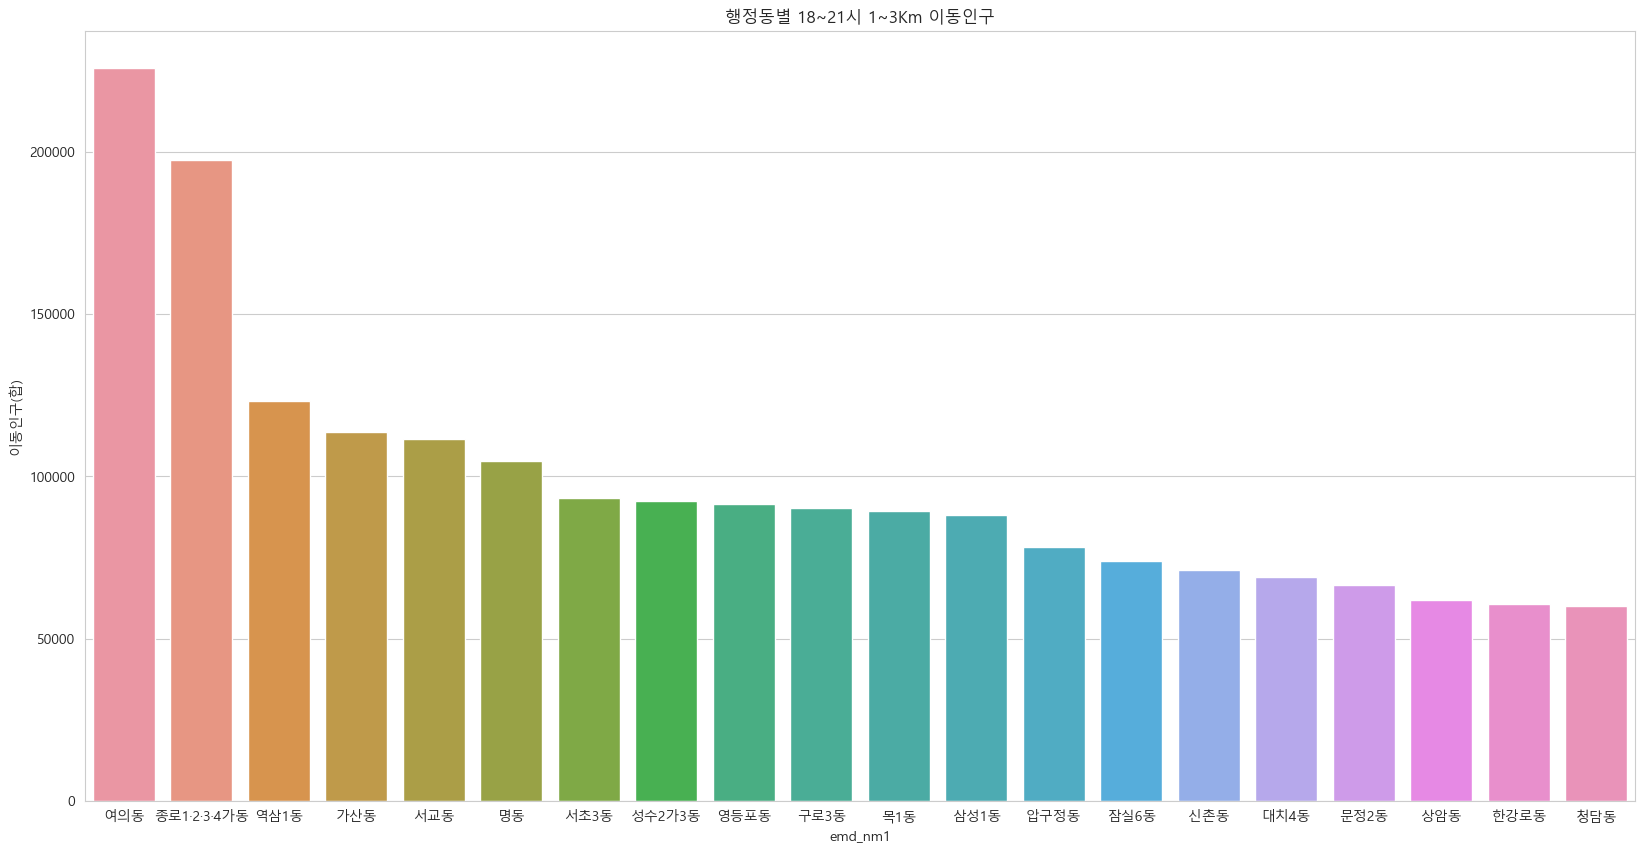

In [22]:
sns.barplot(data=emd_near_move.head(20), x='emd_nm1', y='이동인구(합)')
plt.title('행정동별 18~21시 1~3Km 이동인구')
plt.show()

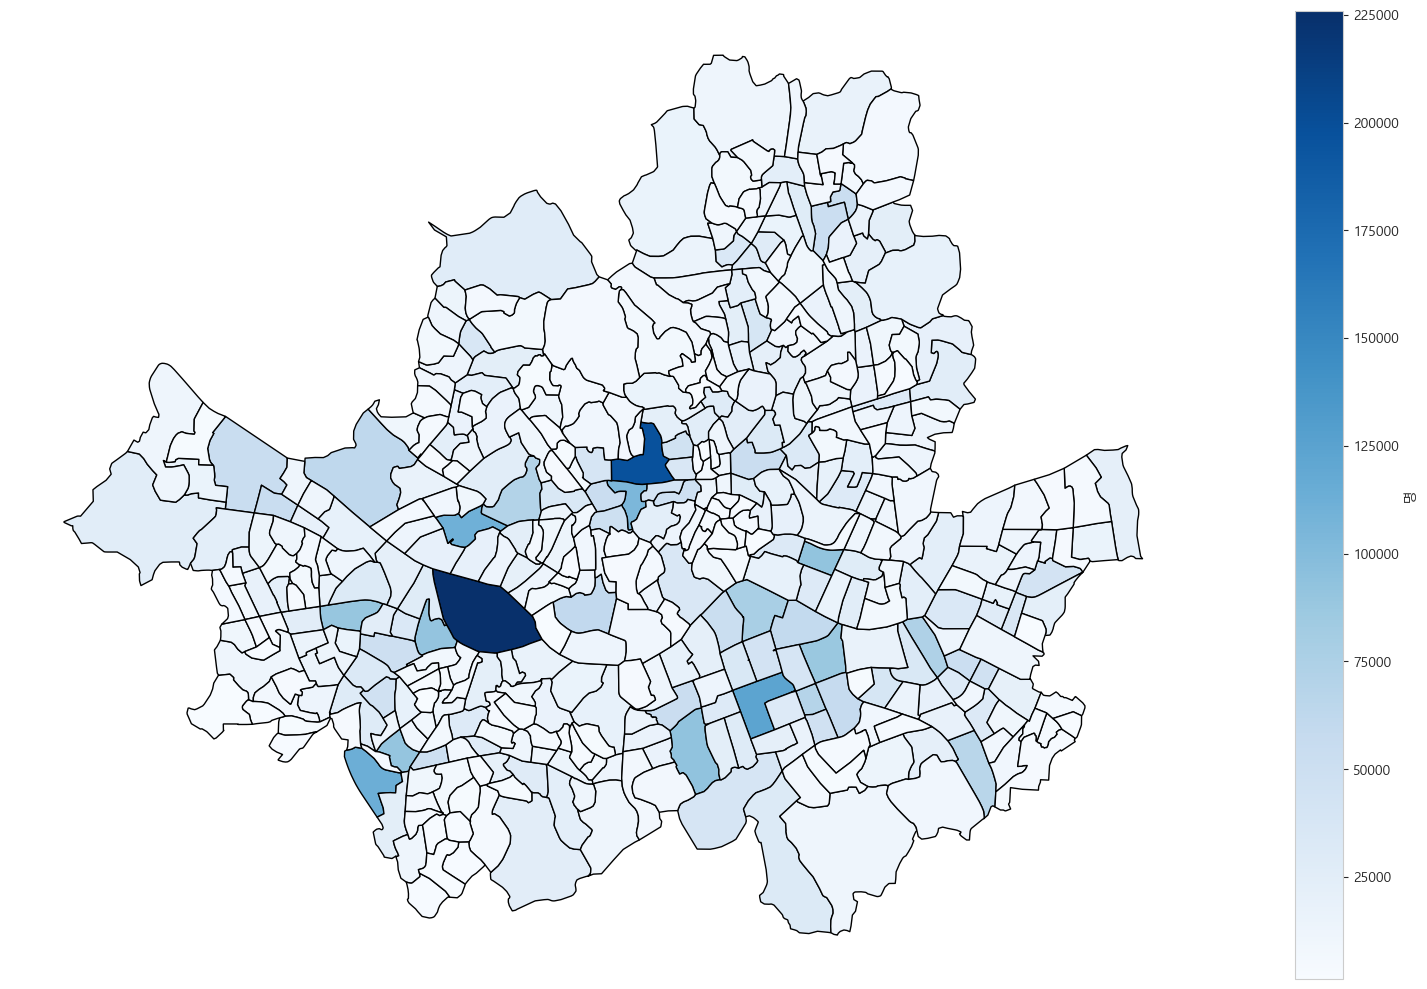

In [23]:
emd_geo = emd_geo_master.loc[:, ['emd_cd', 'emd_nm', 'geometry']]

merged = pd.merge(emd_near_move, emd_geo, left_on='emd_cd1', right_on='emd_cd')
gdf = gpd.GeoDataFrame(merged, geometry='geometry')

show_geo(gdf, column='이동인구(합)')



---